In [12]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import LSTM, Dense, Input

In [2]:
#Plant states from index 0 - 5
plant_states = ["Saludable","Estresada","Deshidratada","Exceso de riego","Deficiencia nutrientes","Enferma"]

In [3]:
# Load the data
dataset = pandas.read_csv('arduinodata_with_plant_state2.csv', parse_dates=['timestamp'])

# Drop the 'id' column
dataset.drop(['id','deviceid'], axis=1, inplace=True)

#TODO: only if we want to encode directly with a string the value
#dataset['state'] = dataset['state'].map(dict(enumerate(plant_states)))

#Set timestamp as index
dataset.set_index('timestamp', inplace=True)

print(dataset)

                            soilmoisture  temperature  airhumidity  \
timestamp                                                            
2024-04-26 23:44:05.022556            86         23.8           26   
2024-04-26 23:15:24.367992            86         24.1           24   
2024-04-26 22:46:54.191467            86         24.4           20   
2024-04-26 22:18:22.945400            86         24.7           17   
2024-04-26 21:49:41.969129            85         25.0           16   
...                                  ...          ...          ...   
2024-04-14 15:55:52.815886            91         23.4           35   
2024-04-14 15:27:01.788713            91         23.2           35   
2024-04-14 14:54:33.597601            88         28.2           28   
2024-04-14 13:51:05.035296            74         27.0           25   
2024-04-14 13:20:30.915587            76         25.2           29   

                            lightlevel  irrigationamount  state  
timestamp              

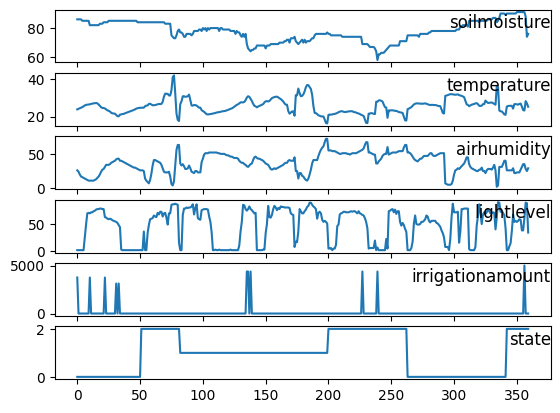

In [4]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pandas.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     
 if i == 0:
     names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
 # put it all together
 agg = pandas.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
    
 return agg

In [21]:
# Ensure all data is float32 except the 'state' column
for col in dataset.columns:
    if col != 'state':
        dataset[col] = dataset[col].astype('float32')

# Separate the 'state' column
state_column = dataset['state']
# Drop the 'state' column from the dataset
numerical_data = dataset.drop('state', axis=1)

# Initialize and apply the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Recombine the scaled numerical data with the 'state' column
scaled_numerical_data = pandas.DataFrame(scaled_numerical_data, columns=numerical_data.columns, index=dataset.index)
scaled_numerical_data['state'] = state_column

# Now transform dataset into a supervised learning format if needed
# For example, assuming series_to_supervised is a function you've defined or it's part of a package you are using:
reframed = series_to_supervised(scaled_numerical_data, 48, 1)

# Drop columns you don't want to predict
# Update index to match dropped features after reframing if necessary
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)

# Display the head of the reframed DataFrame to confirm
print(reframed.tail())

                            var1(t-48)  var2(t-48)  var3(t-48)  var4(t-48)  \
timestamp                                                                    
2024-04-14 15:55:52.815886    0.727273    0.562500    0.457143    0.855556   
2024-04-14 15:27:01.788713    0.727273    0.546875    0.485714    0.866667   
2024-04-14 14:54:33.597601    0.727273    0.472656    0.542857    0.866667   
2024-04-14 13:51:05.035296    0.727273    0.398438    0.614286    0.866667   
2024-04-14 13:20:30.915587    0.696970    0.386719    0.614286    0.866667   

                            var5(t-48)  var6(t-48)  var6(t-47)  var1(t-46)  \
timestamp                                                                    
2024-04-14 15:55:52.815886         0.0         0.0         0.0    0.727273   
2024-04-14 15:27:01.788713         0.0         0.0         0.0    0.727273   
2024-04-14 14:54:33.597601         0.0         0.0         0.0    0.696970   
2024-04-14 13:51:05.035296         0.0         0.0         0.0 

In [22]:
 #Cross validation
# split into train and test sets
values = reframed.values

# 80% for training and 20% for testing
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(249, 1, 288) (249,) (63, 1, 288) (63,)


In [23]:
# Convert labels to integer encodings
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Convert labels to one-hot encodings
train_y_categorical = to_categorical(train_y_encoded)
test_y_categorical = to_categorical(test_y_encoded)

Epoch 1/50
4/4 - 1s - 267ms/step - accuracy: 0.5060 - loss: 1.1528 - val_accuracy: 0.0000e+00 - val_loss: 1.3318
Epoch 2/50
4/4 - 0s - 7ms/step - accuracy: 0.5020 - loss: 0.9658 - val_accuracy: 0.0317 - val_loss: 1.3049
Epoch 3/50
4/4 - 0s - 7ms/step - accuracy: 0.5622 - loss: 0.9037 - val_accuracy: 0.1746 - val_loss: 1.2473
Epoch 4/50
4/4 - 0s - 7ms/step - accuracy: 0.6747 - loss: 0.8634 - val_accuracy: 0.2381 - val_loss: 1.1880
Epoch 5/50
4/4 - 0s - 7ms/step - accuracy: 0.7390 - loss: 0.8315 - val_accuracy: 0.2381 - val_loss: 1.1338
Epoch 6/50
4/4 - 0s - 7ms/step - accuracy: 0.7671 - loss: 0.8007 - val_accuracy: 0.2222 - val_loss: 1.0900
Epoch 7/50
4/4 - 0s - 7ms/step - accuracy: 0.8233 - loss: 0.7681 - val_accuracy: 0.3016 - val_loss: 1.0614
Epoch 8/50
4/4 - 0s - 7ms/step - accuracy: 0.8876 - loss: 0.7313 - val_accuracy: 0.3492 - val_loss: 1.0485
Epoch 9/50
4/4 - 0s - 7ms/step - accuracy: 0.9357 - loss: 0.6901 - val_accuracy: 0.3175 - val_loss: 1.0476
Epoch 10/50
4/4 - 0s - 7ms/step

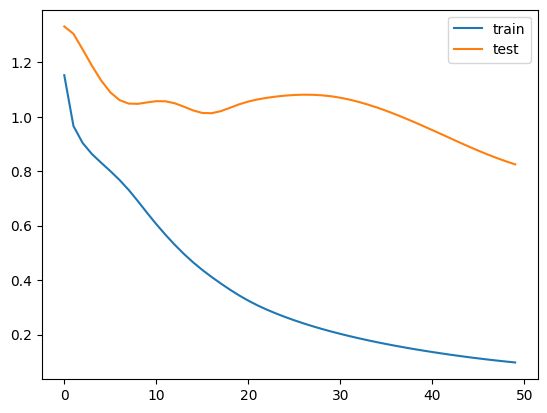

In [42]:
# design network
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(train_y_categorical.shape[1], activation='softmax'))  # Output layer for categorical prediction
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y_categorical, epochs=50, batch_size=72, validation_data=(test_X, test_y_categorical), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
print("Shape of test_X:", test_X.shape)
print("Data type of test_X:", test_X.dtype)
model.summary()

Shape of test_X: (63, 1, 288)
Data type of test_X: float64


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,861 (796.34 KB)

 Trainable params: 67,953 (265.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 135,908 (530.89 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Accuracy: 0.3968253968253968
Confusion Matrix:
 [[11 34  0]
 [ 0  0  0]
 [ 0  4 14]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.24      0.39        45
           1       0.00      0.00      0.00         0
           2       1.00      0.78      0.88        18

    accuracy                           0.40        63
   macro avg       0.67      0.34      0.42        63
weighted avg       1.00      0.40      0.53        63



/mnt/c/Users/apere/Desktop/TFG-SmartPlanter/WebApp/Backend/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/apere/Desktop/TFG-SmartPlanter/WebApp/Backend/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/apere/Desktop/TFG-SmartPlanter/WebApp/Backend/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

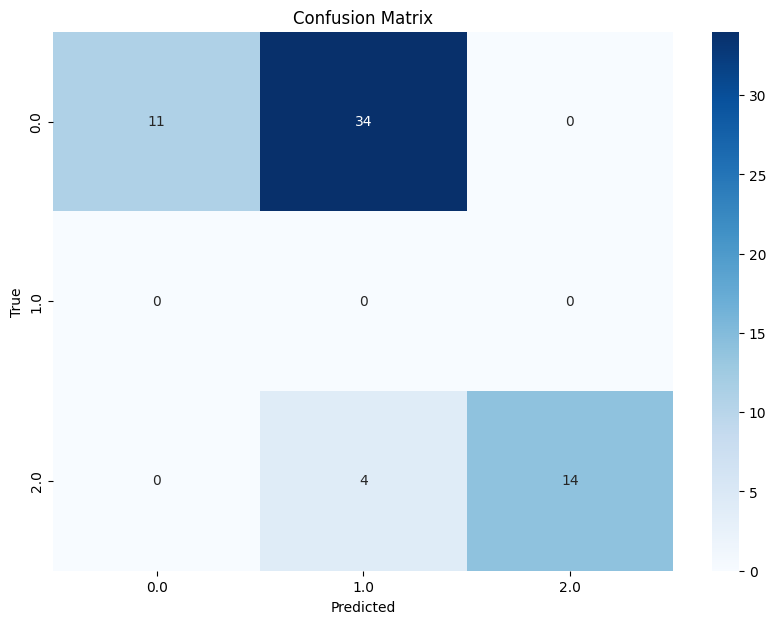

In [44]:
# Step 1: Make predictions
yhat_probs = model.predict(test_X)
yhat_classes = np.argmax(yhat_probs, axis=1)

# Assuming test_y_categorical is one-hot encoded, convert it back to class labels for evaluation
test_y_labels = np.argmax(test_y_categorical, axis=1)

# Step 2: Evaluate the model
accuracy = accuracy_score(test_y_labels, yhat_classes)
print('Accuracy:', accuracy)

# Print the confusion matrix
cm = confusion_matrix(test_y_labels, yhat_classes)
print('Confusion Matrix:\n', cm)

# Print a classification report
report = classification_report(test_y_labels, yhat_classes)
print('Classification Report:\n', report)

# Step 3: Optional visualization - Plot confusion matrix


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()